# Dataset


In [ ]:
data_obj = AlzheimerDataset()

In [ ]:
print('Length of training data:',len(data_obj.train_dataset))
print('Length of test data:',len(data_obj.test_dataset))

Length of training data: 5121
Length of test data: 1279


In [ ]:
print('Shape of training images: ',data_obj.train_dataset[0][0].shape)

Shape of training images:  torch.Size([3, 227, 227])


In [ ]:
count = [0,0,0,0]
for data in data_obj.train_dataset:
  if data[1]==0: count[0]= count[0]+1
  elif data[1]==1: count[1]= count[1]+1
  elif data[1]==2: count[2]= count[2]+1
  else: count[3]= count[3]+1
print('Label0:',count[0], ' Label 1:', count[1], ' Label 2:', count[2], ' Label 3:', count[3])

Label0: 717  Label 1: 52  Label 2: 2560  Label 3: 1792


We are using an Alzheimer's dataset that has images of brain scan categorized into four catogories:
1. Mild Demented

2. Moderate Demented

3. Non Demented

4. Very Mild Demented

The dataset is ***not evenly distributed*** among these 4 classes, where theres only 52 instances for "Moderately Demented" and 2560 data instaces for "Non Demented".

The images shape is 227*227 and has 3 channels (RGB image).


## Visualize random batch of images

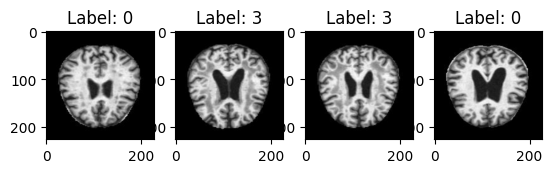

In [ ]:
# Define DataLoader for test dataset
test_loader = DataLoader(data_obj.test_dataset, batch_size=4, shuffle=True)

image, labels = next(iter(test_loader))
# Transpose the image data to channels-last format (H x W x C)
image = image.numpy().transpose((0, 2, 3, 1))
# Ensure that the pixel values are in the range [0, 1]
image = np.clip(image, 0, 1)

# Create subplots
fig, ax = plt.subplots(1, 4)

# Plot each image in a subplot
for i in range(4):
    ax[i].imshow(image[i])
    ax[i].set_title(f"Label: {labels[i]}")

plt.show()

# Imports

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import torch as torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
from torch.autograd import grad
import zipfile

import os


# Initial Model - 67%


 Loss for epoch  0 :  0.05248246714472771

 Accuracy for epoch  0 :  53.70045

 Correct predictions for epoch  0 :  2750

 Loss for epoch  2 :  0.02324080280959606

 Accuracy for epoch  2 :  59.81254

 Correct predictions for epoch  2 :  3063

 Loss for epoch  4 :  0.024147942662239075

 Accuracy for epoch  4 :  66.451866

 Correct predictions for epoch  4 :  3403

 Loss for epoch  6 :  0.023239638656377792

 Accuracy for epoch  6 :  74.223785

 Correct predictions for epoch  6 :  3801

 Loss for epoch  8 :  0.023239662870764732

 Accuracy for epoch  8 :  78.16833

 Correct predictions for epoch  8 :  4003

 Loss for epoch  10 :  0.05447816848754883

 Accuracy for epoch  10 :  78.75415

 Correct predictions for epoch  10 :  4033

 Loss for epoch  12 :  0.023239638656377792

 Accuracy for epoch  12 :  83.57743

 Correct predictions for epoch  12 :  4280

 Loss for epoch  14 :  0.02323964610695839

 Accuracy for epoch  14 :  89.377075

 Correct predictions for epoch  14 :  4577


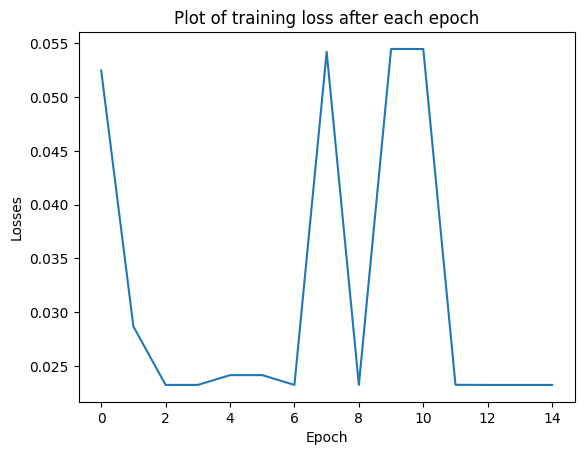

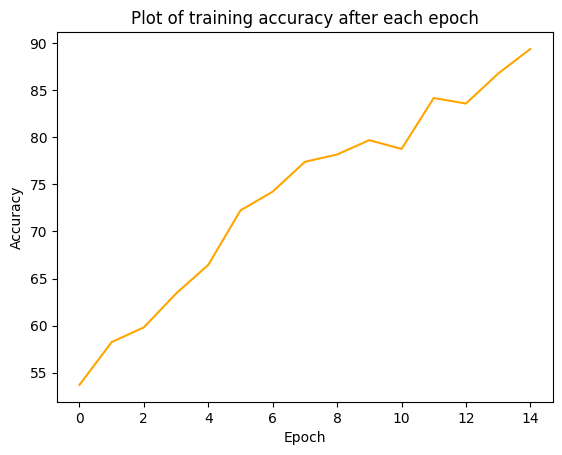

Final Testing Accuracy :  67.78734


In [ ]:


# Check if CUDA (GPU support) is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class AlzheimerDataset(Dataset):
  def __init__(self):
    super().__init__()

    self.transform = transforms.Compose(
        [transforms.Resize((227,227)),
         transforms.ToTensor(),
          transforms.Normalize(0, 1)])

    # Define paths to train and test data inside the zip file
    zip_file_path = 'alzheimer.zip'

    # Define paths to train and test data
    train_data_path = 'Alzheimer_s Dataset/train'
    test_data_path = 'Alzheimer_s Dataset/test'

    with zipfile.ZipFile('alzheimer.zip', 'r') as zip_ref:
      zip_ref.extractall(path='', members=[member for member in zip_ref.namelist() if member.startswith('Alzheimer_s Dataset/')])
    # print(os.listdir("Alzheimer_s Dataset/"))

    # Create datasets
    self.dataset = datasets.ImageFolder('Alzheimer_s Dataset/', transform=self.transform)
    self.train_dataset = datasets.ImageFolder(train_data_path, transform=self.transform)
    self.test_dataset = datasets.ImageFolder(test_data_path, transform=self.transform)

    # # Define data loaders
    # self.train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
    # self.test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

  def __len__(self):
      return len(self.dataset)

  def __getitem__(self, idx):
      image, label = self.dataset[idx]
      # Further processing if needed
      return image, label



class AlexNet(torch.nn.Module):
  def __init__(self):
    super(AlexNet,self).__init__()
    # Define the model layers
    self.conv1 = nn.Conv2d(3,96, kernel_size = 11, stride = 4)
    self.conv2 = nn.Conv2d(96,256, kernel_size = 5, stride = 1,padding=2)
    self.conv3 = nn.Conv2d(256,384,kernel_size=3, stride = 1, padding = 1)
    self.conv4 = nn.Conv2d(384,384, kernel_size = 3, stride = 1, padding = 1)
    self.conv5 = nn.Conv2d(384,256,kernel_size=3, stride = 1, padding = 1)
    self.fc1 = nn.Linear(256*6*6,9216)
    self.fc2 = nn.Linear(9216,4096)
    self.fc3 = nn.Linear(4096,4)
    self.dropout = nn.Dropout(p=0.5, inplace=False)
    self.bn1 = nn.BatchNorm2d(96)  # Add batch normalization
    self.bn2 = nn.BatchNorm2d(256)  # Add batch normalization

    # Apply He initialization to the ReLU-based layers
    nn.init.kaiming_uniform_(self.conv1.weight, nonlinearity='relu')
    nn.init.kaiming_uniform_(self.fc1.weight, nonlinearity='relu')

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.bn1(x)  # Add batch normalization
    x = F.max_pool2d(x, kernel_size = 3, stride = 2)
    x = F.relu(self.conv2(x))
    x = self.bn2(x)  # Add batch normalization
    x = F.max_pool2d(x, kernel_size = 3, stride = 2)
    x = F.relu(self.conv3(x))
    x = F.relu(self.conv4(x))
    x = F.relu(self.conv5(x))
    x = F.max_pool2d(x, kernel_size = 3, stride = 2)
    x = x.view(x.size(0), -1)
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = F.relu(self.fc2(x))
    x = self.dropout(x)
    x = F.softmax(self.fc3(x),dim = -1)
    return x




# MAIN PROGRAM
data_obj = AlzheimerDataset()
model = AlexNet().to(device)

#------------------------------------------------------------------------------
#     TRAINING
#------------------------------------------------------------------------------
batch_size = 64
num_epochs = 15
total_train = len(data_obj.train_dataset)#50000   # Total data points in the training dataset
all_losses = list()
all_accuracies = list()
dataloader = DataLoader(data_obj.train_dataset, batch_size=batch_size, shuffle=True)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = 0.0001, betas=(0.9, 0.999), weight_decay=0.0005)

for epoch in range(num_epochs):
  correct = 0
  loss = 0.0
  model.train()
  # batch = 0
  for images,labels in dataloader:
  #----------------------------------------------------------------------------------------
  #--------------------------------TRAINING LOSS-------------------------------------------
  #----------------------------------------------------------------------------------------
    images,labels = images.to(device),labels.to(device)

    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    loss += loss.item()

    # torch.max() returns two outputs, the maximum values and the corresponding index
    # We are intersted in the index, which is equivalent to the predicted digit
    _ ,predictions =  torch.max(outputs.data,1)     # Get maximum values in the output tensor, along the second dimension

    # Compare the predictions against labels, and count the correct ones
    batch_accuracy = sum([predictions[i] == labels[i] for i in range(0,images.shape[0])])
    correct += batch_accuracy
  if epoch %2==0:
    print('\n Loss for epoch ',epoch,': ',loss.item()/batch_size)
    print('\n Accuracy for epoch ',epoch,': ',(correct*100/total_train).cpu().numpy())
    print('\n Correct predictions for epoch ',epoch,': ',correct.cpu().numpy())

  all_losses.append(loss.item()/batch_size)
  all_accuracies.append((correct*100/total_train).cpu().numpy())


# PLOT THE LOSSES
plt.plot(list(range(num_epochs)),all_losses)
plt.xlabel("Epoch")
plt.ylabel("Losses")
plt.title("Plot of training loss after each epoch")
plt.show()

# PLOT THE ACCURACY
plt.plot(list(range(num_epochs)),all_accuracies,color= "orange")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Plot of training accuracy after each epoch")
plt.show()

#------------------------------------------------------------------------------
#     TESTING
#------------------------------------------------------------------------------
test_loader = DataLoader(data_obj.test_dataset, batch_size=batch_size)

model.eval()
correct = 0
total_test = len(data_obj.test_dataset)#10000    # Total data points in the testing dataset
with torch.no_grad():
  for images, labels in test_loader:
    images,labels = images.to(device),labels.to(device)
    outputs = model(images)

    # torch.max() returns two outputs, the maximum values and the corresponding index
    # We are intersted in the index, which is equivalent to the predicted digit
    _ ,predictions =  torch.max(outputs.data,1)     # Get maximum values in the output tensor, along the second dimension

    # Compare the predictions against labels, and count the correct ones
    correct += sum([predictions[i] == labels[i] for i in range(0,images.shape[0])])

print('Final Testing Accuracy : ',(correct*100/total_test).cpu().numpy())

# Introduce Data Augmentation - 57%


 Loss for epoch  0 :  0.05448963865637779

 Accuracy for epoch  0 :  49.580162

 Correct predictions for epoch  0 :  2539

 Loss for epoch  2 :  0.023239638656377792

 Accuracy for epoch  2 :  49.99024

 Correct predictions for epoch  2 :  2560

 Loss for epoch  4 :  0.023239638656377792

 Accuracy for epoch  4 :  49.99024

 Correct predictions for epoch  4 :  2560

 Loss for epoch  6 :  0.023239638656377792

 Accuracy for epoch  6 :  49.99024

 Correct predictions for epoch  6 :  2560

 Loss for epoch  8 :  0.05448963865637779

 Accuracy for epoch  8 :  49.99024

 Correct predictions for epoch  8 :  2560

 Loss for epoch  10 :  0.04213516414165497

 Accuracy for epoch  10 :  51.064247

 Correct predictions for epoch  10 :  2615

 Loss for epoch  12 :  0.028316253796219826

 Accuracy for epoch  12 :  53.680923

 Correct predictions for epoch  12 :  2749

 Loss for epoch  14 :  0.05206692963838577

 Accuracy for epoch  14 :  55.321228

 Correct predictions for epoch  14 :  2833


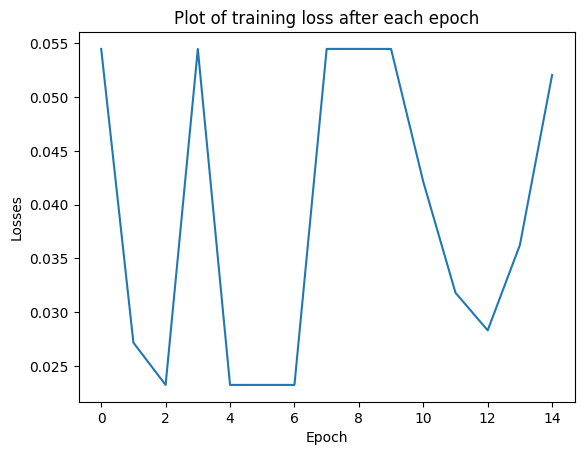

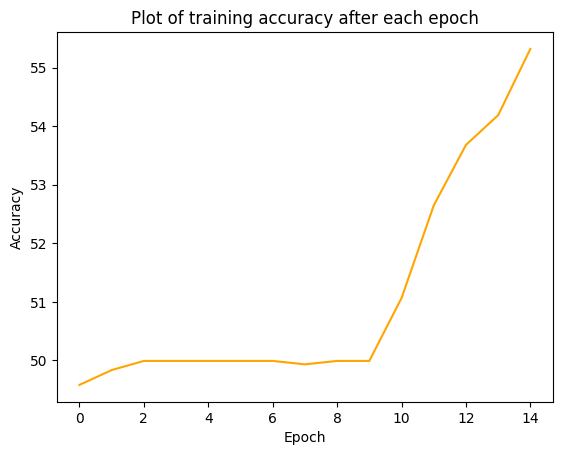

Final Testing Accuracy :  57.07584


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import torch as torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
from torch.autograd import grad
import zipfile

import os


# Check if CUDA (GPU support) is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class AlzheimerDataset(Dataset):
  def __init__(self):
    super().__init__()

    self.transform = transforms.Compose(
        [transforms.Resize((227,227)),
         transforms.RandomRotation(degrees=20),
         transforms.RandomHorizontalFlip(),
         transforms.RandomVerticalFlip(p = 0.3),
         transforms.ToTensor(),
          transforms.Normalize(0, 1)])

    # Define paths to train and test data inside the zip file
    zip_file_path = 'alzheimer.zip'

    # Define paths to train and test data
    train_data_path = 'Alzheimer_s Dataset/train'
    test_data_path = 'Alzheimer_s Dataset/test'

    with zipfile.ZipFile('alzheimer.zip', 'r') as zip_ref:
      zip_ref.extractall(path='', members=[member for member in zip_ref.namelist() if member.startswith('Alzheimer_s Dataset/')])
    # print(os.listdir("Alzheimer_s Dataset/"))

    # Create datasets
    self.dataset = datasets.ImageFolder('Alzheimer_s Dataset/', transform=self.transform)
    self.train_dataset = datasets.ImageFolder(train_data_path, transform=self.transform)
    self.test_dataset = datasets.ImageFolder(test_data_path, transform=self.transform)

    # # Define data loaders
    # self.train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
    # self.test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

  def __len__(self):
      return len(self.dataset)

  def __getitem__(self, idx):
      image, label = self.dataset[idx]
      # Further processing if needed
      return image, label



class AlexNet(torch.nn.Module):
  def __init__(self):
    super(AlexNet,self).__init__()
    # Define the model layers
    self.conv1 = nn.Conv2d(3,96, kernel_size = 11, stride = 4)
    self.conv2 = nn.Conv2d(96,256, kernel_size = 5, stride = 1,padding=2)
    self.conv3 = nn.Conv2d(256,384,kernel_size=3, stride = 1, padding = 1)
    self.conv4 = nn.Conv2d(384,384, kernel_size = 3, stride = 1, padding = 1)
    self.conv5 = nn.Conv2d(384,256,kernel_size=3, stride = 1, padding = 1)
    self.fc1 = nn.Linear(256*6*6,9216)
    self.fc2 = nn.Linear(9216,4096)
    self.fc3 = nn.Linear(4096,4)
    self.dropout = nn.Dropout(p=0.5, inplace=False)
    self.bn1 = nn.BatchNorm2d(96)  # Add batch normalization
    self.bn2 = nn.BatchNorm2d(256)  # Add batch normalization

    # Apply He initialization to the ReLU-based layers
    nn.init.kaiming_uniform_(self.conv1.weight, nonlinearity='relu')
    nn.init.kaiming_uniform_(self.fc1.weight, nonlinearity='relu')

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.bn1(x)  # Add batch normalization
    x = F.max_pool2d(x, kernel_size = 3, stride = 2)
    x = F.relu(self.conv2(x))
    x = self.bn2(x)  # Add batch normalization
    x = F.max_pool2d(x, kernel_size = 3, stride = 2)
    x = F.relu(self.conv3(x))
    x = F.relu(self.conv4(x))
    x = F.relu(self.conv5(x))
    x = F.max_pool2d(x, kernel_size = 3, stride = 2)
    x = x.view(x.size(0), -1)
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = F.relu(self.fc2(x))
    x = self.dropout(x)
    x = F.softmax(self.fc3(x),dim = -1)
    return x




# MAIN PROGRAM
data_obj = AlzheimerDataset()
model = AlexNet().to(device)

#------------------------------------------------------------------------------
#     TRAINING
#------------------------------------------------------------------------------
batch_size = 64
num_epochs = 15
total_train = len(data_obj.train_dataset)#50000   # Total data points in the training dataset
all_losses = list()
all_accuracies = list()
dataloader = DataLoader(data_obj.train_dataset, batch_size=batch_size, shuffle=True)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = 0.0001, betas=(0.9, 0.999), weight_decay=0.0005)

for epoch in range(num_epochs):
  correct = 0
  loss = 0.0
  model.train()
  # batch = 0
  for images,labels in dataloader:
  #----------------------------------------------------------------------------------------
  #--------------------------------TRAINING LOSS-------------------------------------------
  #----------------------------------------------------------------------------------------
    images,labels = images.to(device),labels.to(device)

    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    loss += loss.item()

    # torch.max() returns two outputs, the maximum values and the corresponding index
    # We are intersted in the index, which is equivalent to the predicted digit
    _ ,predictions =  torch.max(outputs.data,1)     # Get maximum values in the output tensor, along the second dimension

    # Compare the predictions against labels, and count the correct ones
    batch_accuracy = sum([predictions[i] == labels[i] for i in range(0,images.shape[0])])
    correct += batch_accuracy
  if epoch %2==0:
    print('\n Loss for epoch ',epoch,': ',loss.item()/batch_size)
    print('\n Accuracy for epoch ',epoch,': ',(correct*100/total_train).cpu().numpy())
    print('\n Correct predictions for epoch ',epoch,': ',correct.cpu().numpy())

  all_losses.append(loss.item()/batch_size)
  all_accuracies.append((correct*100/total_train).cpu().numpy())


# PLOT THE LOSSES
plt.plot(list(range(num_epochs)),all_losses)
plt.xlabel("Epoch")
plt.ylabel("Losses")
plt.title("Plot of training loss after each epoch")
plt.show()

# PLOT THE ACCURACY
plt.plot(list(range(num_epochs)),all_accuracies,color= "orange")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Plot of training accuracy after each epoch")
plt.show()

#------------------------------------------------------------------------------
#     TESTING
#------------------------------------------------------------------------------
test_loader = DataLoader(data_obj.test_dataset, batch_size=batch_size)

model.eval()
correct = 0
total_test = len(data_obj.test_dataset)#10000    # Total data points in the testing dataset
with torch.no_grad():
  for images, labels in test_loader:
    images,labels = images.to(device),labels.to(device)
    outputs = model(images)

    # torch.max() returns two outputs, the maximum values and the corresponding index
    # We are intersted in the index, which is equivalent to the predicted digit
    _ ,predictions =  torch.max(outputs.data,1)     # Get maximum values in the output tensor, along the second dimension

    # Compare the predictions against labels, and count the correct ones
    correct += sum([predictions[i] == labels[i] for i in range(0,images.shape[0])])

print('Final Testing Accuracy : ',(correct*100/total_test).cpu().numpy())

# New Section


 Loss for epoch  0 :  0.046479277312755585

 Accuracy for epoch  0 :  49.794964

 Correct predictions for epoch  0 :  2550

 Loss for epoch  2 :  0.10897927731275558

 Accuracy for epoch  2 :  49.99024

 Correct predictions for epoch  2 :  2560

 Loss for epoch  4 :  0.10897927731275558

 Accuracy for epoch  4 :  49.99024

 Correct predictions for epoch  4 :  2560

 Loss for epoch  6 :  0.046479277312755585

 Accuracy for epoch  6 :  49.99024

 Correct predictions for epoch  6 :  2560

 Loss for epoch  8 :  0.10897927731275558

 Accuracy for epoch  8 :  49.99024

 Correct predictions for epoch  8 :  2560

 Loss for epoch  10 :  0.06827659904956818

 Accuracy for epoch  10 :  49.541107

 Correct predictions for epoch  10 :  2537

 Loss for epoch  12 :  0.10897927731275558

 Accuracy for epoch  12 :  49.99024

 Correct predictions for epoch  12 :  2560

 Loss for epoch  14 :  0.10897927731275558

 Accuracy for epoch  14 :  53.46612

 Correct predictions for epoch  14 :  2738


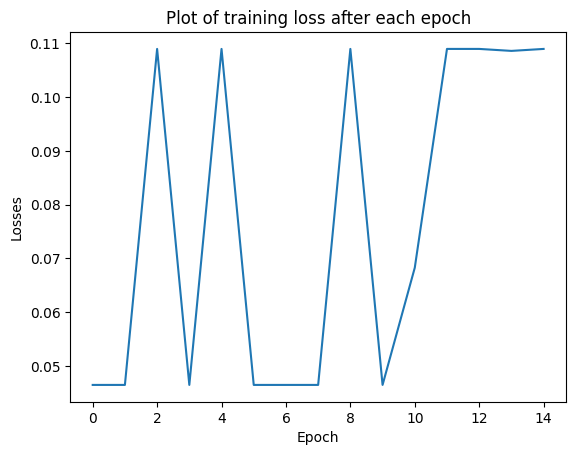

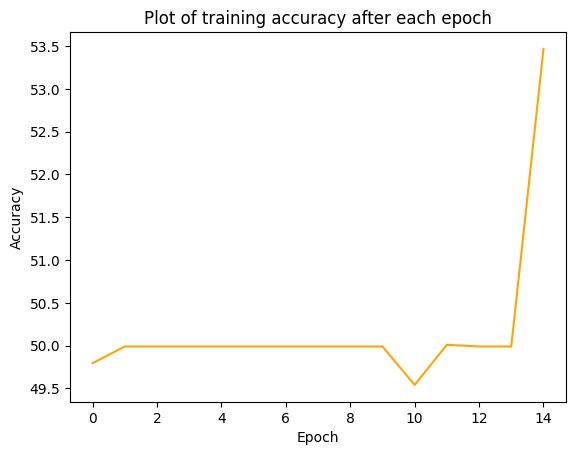

Final Testing Accuracy :  50.195465


In [ ]:


# Check if CUDA (GPU support) is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class AlzheimerDataset(Dataset):
  def __init__(self):
    super().__init__()

    self.transform = transforms.Compose(
        [transforms.Resize((227,227)),
         transforms.ToTensor(),
          transforms.Normalize(0, 1)])

    # Define paths to train and test data inside the zip file
    zip_file_path = 'alzheimer.zip'

    # Define paths to train and test data
    train_data_path = 'Alzheimer_s Dataset/train'
    test_data_path = 'Alzheimer_s Dataset/test'

    with zipfile.ZipFile('alzheimer.zip', 'r') as zip_ref:
      zip_ref.extractall(path='', members=[member for member in zip_ref.namelist() if member.startswith('Alzheimer_s Dataset/')])
    # print(os.listdir("Alzheimer_s Dataset/"))

    # Create datasets
    self.dataset = datasets.ImageFolder('Alzheimer_s Dataset/', transform=self.transform)
    self.train_dataset = datasets.ImageFolder(train_data_path, transform=self.transform)
    self.test_dataset = datasets.ImageFolder(test_data_path, transform=self.transform)

    # # Define data loaders
    # self.train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
    # self.test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

  def __len__(self):
      return len(self.dataset)

  def __getitem__(self, idx):
      image, label = self.dataset[idx]
      # Further processing if needed
      return image, label



class AlexNet(torch.nn.Module):
  def __init__(self):
    super(AlexNet,self).__init__()
    # Define the model layers
    self.conv1 = nn.Conv2d(3,96, kernel_size = 11, stride = 4)
    self.conv2 = nn.Conv2d(96,256, kernel_size = 5, stride = 1,padding=2)
    self.conv3 = nn.Conv2d(256,384,kernel_size=3, stride = 1, padding = 1)
    self.conv4 = nn.Conv2d(384,384, kernel_size = 3, stride = 1, padding = 1)
    self.conv5 = nn.Conv2d(384,256,kernel_size=3, stride = 1, padding = 1)
    self.fc1 = nn.Linear(256*6*6,9216)
    self.fc2 = nn.Linear(9216,4096)
    self.fc3 = nn.Linear(4096,4)
    self.dropout = nn.Dropout(p=0.5, inplace=False)
    self.bn1 = nn.BatchNorm2d(96)  # Add batch normalization
    self.bn2 = nn.BatchNorm2d(256)  # Add batch normalization

    # Apply He initialization to the ReLU-based layers
    nn.init.kaiming_uniform_(self.conv1.weight, nonlinearity='relu')
    nn.init.kaiming_uniform_(self.fc1.weight, nonlinearity='relu')

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.bn1(x)  # Add batch normalization
    x = F.max_pool2d(x, kernel_size = 3, stride = 2)
    x = F.relu(self.conv2(x))
    x = self.bn2(x)  # Add batch normalization
    x = F.max_pool2d(x, kernel_size = 3, stride = 2)
    x = F.relu(self.conv3(x))
    x = F.relu(self.conv4(x))
    x = F.relu(self.conv5(x))
    x = F.max_pool2d(x, kernel_size = 3, stride = 2)
    x = x.view(x.size(0), -1)
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = F.relu(self.fc2(x))
    x = self.dropout(x)
    x = F.softmax(self.fc3(x),dim = -1)
    return x




# MAIN PROGRAM
data_obj = AlzheimerDataset()
model = AlexNet().to(device)

#------------------------------------------------------------------------------
#     TRAINING
#------------------------------------------------------------------------------
batch_size = 32
num_epochs = 15
total_train = len(data_obj.train_dataset)#50000   # Total data points in the training dataset
all_losses = list()
all_accuracies = list()
dataloader = DataLoader(data_obj.train_dataset, batch_size=batch_size, shuffle=True)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = 0.0001, betas=(0.9, 0.999), weight_decay=0.0005)

for epoch in range(num_epochs):
  correct = 0
  loss = 0.0
  model.train()
  # batch = 0
  for images,labels in dataloader:
  #----------------------------------------------------------------------------------------
  #--------------------------------TRAINING LOSS-------------------------------------------
  #----------------------------------------------------------------------------------------
    images,labels = images.to(device),labels.to(device)

    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    loss += loss.item()

    # torch.max() returns two outputs, the maximum values and the corresponding index
    # We are intersted in the index, which is equivalent to the predicted digit
    _ ,predictions =  torch.max(outputs.data,1)     # Get maximum values in the output tensor, along the second dimension

    # Compare the predictions against labels, and count the correct ones
    batch_accuracy = sum([predictions[i] == labels[i] for i in range(0,images.shape[0])])
    correct += batch_accuracy
  if epoch %2==0:
    print('\n Loss for epoch ',epoch,': ',loss.item()/batch_size)
    print('\n Accuracy for epoch ',epoch,': ',(correct*100/total_train).cpu().numpy())
    print('\n Correct predictions for epoch ',epoch,': ',correct.cpu().numpy())

  all_losses.append(loss.item()/batch_size)
  all_accuracies.append((correct*100/total_train).cpu().numpy())


# PLOT THE LOSSES
plt.plot(list(range(num_epochs)),all_losses)
plt.xlabel("Epoch")
plt.ylabel("Losses")
plt.title("Plot of training loss after each epoch")
plt.show()

# PLOT THE ACCURACY
plt.plot(list(range(num_epochs)),all_accuracies,color= "orange")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Plot of training accuracy after each epoch")
plt.show()

#------------------------------------------------------------------------------
#     TESTING
#------------------------------------------------------------------------------
test_loader = DataLoader(data_obj.test_dataset, batch_size=batch_size)

model.eval()

all_preds = list()
all_labels = list()

correct = 0
total_test = len(data_obj.test_dataset)#10000    # Total data points in the testing dataset
with torch.no_grad():
  for images, labels in test_loader:
    images,labels = images.to(device),labels.to(device)
    outputs = model(images)

    # torch.max() returns two outputs, the maximum values and the corresponding index
    # We are intersted in the index, which is equivalent to the predicted digit
    _ ,predictions =  torch.max(outputs.data,1)     # Get maximum values in the output tensor, along the second dimension

    all_preds.append(predictions.to("cpu"))
    all_labels.append(labels.to("cpu"))

    # Compare the predictions against labels, and count the correct ones
    correct += sum([predictions[i] == labels[i] for i in range(0,images.shape[0])])

print('Final Testing Accuracy : ',(correct*100/total_test).cpu().numpy())

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# Calculate Classification Accuracy
accuracy = torch.sum(torch.tensor(all_preds) == torch.tensor(all_labels)).item() / len(all_preds)

# Calculate Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Calculate Precision, Recall, F1 Score
report = classification_report(all_labels, all_preds)

# Convert the tensors to numpy arrays
all_preds_np = torch.tensor(all_preds).numpy()
all_labels_np = torch.tensor(all_labels).numpy()

# Calculate Precision, Recall, F1 Score
precision = (all_preds_np & all_labels_np).sum() / all_preds_np.sum()
recall = (all_preds_np & all_labels_np).sum() / all_labels_np.sum()
f1_score = 2 * (precision * recall) / (precision + recall)

# Calculate ROC Curve and AUC
# Assuming binary classification
# roc_auc = roc_auc_score(all_labels_np, all_preds_np)

# Print or use the computed metrics as needed
print("Classification Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)
# print("ROC AUC Score:", roc_auc)

TypeError: only integer tensors of a single element can be converted to an index